In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
df_label = pd.read_csv("/content/drive/Shared drives/Artists!/data_modified/result_pa.csv",index_col=0)
# df_label["tracks_id"] = df_label["tracks_id"].map(lambda x: str(x).zfill(6))
df_label = df_label.sample(frac=1).reset_index(drop=True)
df_train = df_label[:int(0.8*len(df_label))]
df_val = df_label[int(0.8*len(df_label)):int(0.9*len(df_label))]
df_test = df_label[int(0.9*len(df_label)):]

In [0]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
AUDIO_DIR = '/content/drive/Shared drives/Artists!/data/fma_medium'

In [0]:
#convert mp3 to spectogram
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [0]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [0]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

(646, 128)


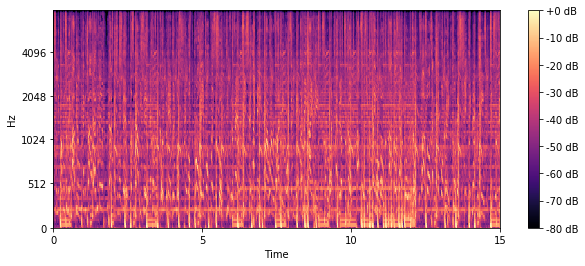

In [0]:
#plot example
plot_spect(2)

In [0]:
#convert data to array
def create_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['tracks_id'])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(row['genres_all'])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr


In [0]:
x_train, y_train = create_array(df_train)
np.savez('/content/drive/Shared drives/Artists!/data_modified/train_arr', x_train, y_train)

In [0]:
x_val, y_val = create_array(df_val)
np.savez('/content/drive/Shared drives/Artists!/data_modified/val_arr', x_val, y_val)
x_test, y_test = create_array(df_test)
np.savez('/content/drive/Shared drives/Artists!/data_modified/test_arr', x_test, y_test)

In [0]:
print(x_train.shape, y_train.shape)

In [0]:
import numpy as np
trainfile = np.load('/content/drive/Shared drives/Artists!/data_modified/train_arr.npz')
x_train = trainfile['arr_0']
y_train = trainfile['arr_1']
print(x_train.shape, y_train.shape)
x_train_raw = librosa.core.db_to_power(x_train, ref=1.0)
y_train_one = np.array(pd.get_dummies(y_train))
np.savez('/content/drive/Shared drives/Artists!/data_modified/train_raw', x_train_raw, y_train_one)

(6527, 640, 128) (6527,)


In [0]:
x_train_log = np.log(x_train_raw)
np.savez('/content/drive/Shared drives/Artists!/data_modified/train_log', x_train_log, y_train_one)

In [0]:
val = np.load('/content/drive/Shared drives/Artists!/data_modified/val_arr.npz')
x_val = val['arr_0']
y_val = val['arr_1']
print(x_val.shape, y_val.shape)
x_val_raw = librosa.core.db_to_power(x_val, ref=1.0)
y_val_one = np.array(pd.get_dummies(y_val))
np.savez('/content/drive/Shared drives/Artists!/data_modified/val_raw', x_val_raw, y_val_one)

In [0]:
x_val_log = np.log(x_val_raw)
np.savez('/content/drive/Shared drives/Artists!/data_modified/val_log', x_val_log, y_val_one)

In [0]:
test = np.load('/content/drive/Shared drives/Artists!/data_modified/test_arr.npz')
x_test = test['arr_0']
y_test = test['arr_1']
print(x_test.shape, y_test.shape)
x_test_raw = librosa.core.db_to_power(x_test, ref=1.0)
np.savez('/content/drive/Shared drives/Artists!/data_modified/test_raw', x_test_raw, y_test)

In [0]:
x_test_log = np.log(x_test_raw)
np.savez('/content/drive/Shared drives/Artists!/data_modified/test_log', x_test_log, y_test)